In [20]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import matplotlib.pyplot as plt

In [156]:
bins

{'bin0': ['2021-03-07 15:00', '2021-03-08 09:30'],
 'bin1': ['2021-03-08 09:30', '2021-03-08 09:39'],
 'bin2': ['2021-03-08 09:39', '2021-03-08 09:48'],
 'bin3': ['2021-03-08 09:48', '2021-03-08 09:57'],
 'bin4': ['2021-03-08 09:57', '2021-03-08 10:06'],
 'bin5': ['2021-03-08 10:06', '2021-03-08 10:15'],
 'bin6': ['2021-03-08 10:15', '2021-03-08 10:24'],
 'bin7': ['2021-03-08 10:24', '2021-03-08 10:33'],
 'bin8': ['2021-03-08 10:33', '2021-03-08 10:42'],
 'bin9': ['2021-03-08 10:42', '2021-03-08 10:51'],
 'bin10': ['2021-03-08 10:51', '2021-03-08 11:30'],
 'bin11': ['2021-03-08 11:30', '2021-03-08 13:00'],
 'bin12': ['2021-03-08 13:00', '2021-03-08 13:09'],
 'bin13': ['2021-03-08 13:09', '2021-03-08 13:18'],
 'bin14': ['2021-03-08 13:18', '2021-03-08 13:27'],
 'bin15': ['2021-03-08 13:27', '2021-03-08 13:36'],
 'bin16': ['2021-03-08 13:36', '2021-03-08 13:45'],
 'bin17': ['2021-03-08 13:45', '2021-03-08 13:54'],
 'bin18': ['2021-03-08 13:54', '2021-03-08 14:03'],
 'bin19': ['2021-03-08

In [14]:
def df2matrix(file_path:str, 
                col_name: str=None, 
                bin_num: bool= True):
    """
    转换数据结构，以date为横坐标，制定col_name为纵坐标
    """

    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df.set_index('date', inplace= True)
    df.sort_index(inplace= True)
    n, k = df.shape[0], 25
    if bin_num:
        data = pd.DataFrame(np.array(df[col_name]).reshape(int(n/k), k),
                                columns= ['bin{}'.format(i) for i in range(k)]).drop('bin0', axis=1)
    else:
        bin0_list, mean_col_name = [], np.mean(df[col_name])
        for i in range(0, df.shape[0], 25):
            if df[col_name].iloc[i- 25] == 0:
                bin0_list.append([(df[col_name].iloc[i]- df[col_name].iloc[i-25])/ mean_col_name])
            elif i == 0:
                bin0_list.append([(df[col_name].iloc[i]- df[col_name].iloc[i])/ df[col_name].iloc[i]])
            elif i != 0:
                bin0_list.append([(df[col_name].iloc[i]- df[col_name].iloc[i-25])/ df[col_name].iloc[i-25] ])
        result = np.array([[element[0]]*(k-1) for element in bin0_list])
        # print(result.shape)
        data = pd.DataFrame(np.array(result),
                            columns= ['bin0' for i in range(k-1)])
    data['date'] = pd.to_datetime(list(sorted(set(df.index))), format='%Y/%m/%d')
    data.set_index('date', inplace= True)
    data.sort_index(inplace=True)
    return data

def genNewFeature4BinVolume(stock_info,
                            file_data,
                            file_comment,
                            lag_day= 3,
                            lag_bin= 3,
                            lag_week = 1):
    """create the data
    """
    mdata = df2matrix(file_data,'bin_volume')
    result = pd.DataFrame(index=mdata.index, columns=mdata.columns)

    
    f0 = df2matrix(file_data, 'bin_volume', False)
    f1 = mdata
    f2 = pd.DataFrame(index=mdata.index, columns=mdata.columns)
    f3 = pd.DataFrame(index=mdata.index, columns=mdata.columns)
    f4 = pd.DataFrame(index=mdata.index, columns=mdata.columns)
    f5 = pd.DataFrame(index=mdata.index, columns=mdata.columns)
    f6 = df2matrix(file_data, 'volatility')
    f7 = df2matrix(file_data, 'quote_imbalance')
    f8 = pd.read_csv(file_comment, index_col= 'Unnamed: 0')
    try:
        f0 = (f0.values+ f8['bin0'].values.reshape(f0.shape[0], 1)) # 直接将bin0的评论 和 f0的所有特征相加
    except ValueError:
        print(f8['bin0'].values.shape, f0.shape, stock_info)
    f8 = f8.iloc[:, 1:]

    daily_volume = mdata.apply(lambda x: x.sum(), axis=1) 
    for i in range(len(mdata.index)):
        for j in range(len(mdata.columns)):
            f2.iloc[i, j] =  np.sum(mdata.iloc[i, :j+1])

            if j<lag_bin-1:
                bin_volume = mdata.iloc[i, :j+1]
                f3.iloc[i,j] =  np.mean(bin_volume)
            else:
                bin_volume = mdata.iloc[i,j-lag_bin+1:j+1]
                f3.iloc[i,j] =  np.mean(bin_volume)

            if i<lag_day-1:
                pro_volume = mdata.iloc[:i+1, j]/daily_volume[:i+1]
                f4.iloc[i, j] =  np.mean(pro_volume)
            else:
                pro_volume = mdata.iloc[i-lag_day+1:i+1, j]/daily_volume[i-lag_day+1:i+1]
                f4.iloc[i, j] =  np.mean(pro_volume)

            if i<5:      
                f5.iloc[i, j] = mdata.iloc[0, j]
            else:
                f5.iloc[i, j] =  mdata.iloc[i-5, j]

            f_all = [f0[i, j], f1.iloc[i, j], f2.iloc[i, j], f3.iloc[i, j],
                        f4.iloc[i, j], f5.iloc[i, j], f6.iloc[i, j], f7.iloc[i, j], f8.iloc[i, j]]

            f_all = [0 if np.isnan(i) else i for i in f_all]
            result.iloc[i, j] = [float('{:.4f}'.format(i)) for i in f_all]      

    # result.to_csv(f'../data/volume/0308/Features/{stock_info}_25_daily_f_all.csv')
    
    return result

result = genNewFeature4BinVolume(stock_info= None, 
                                 file_data= '../data/0308/0308-data/000046_XSHE_25_daily.csv',
                                 file_comment= '../data/0308/0308-number/000046_comment_sentiment.csv')

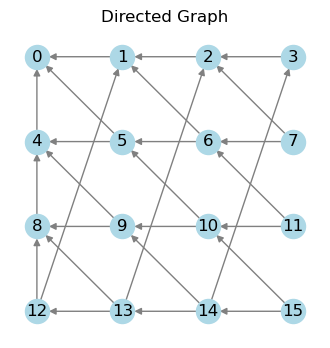

In [23]:
def gen_adjacency_matrix_leftup(lag_bin, lag_day):
    matrix_size = (lag_bin +1)*(lag_day + 1) 
    adj_matrix = np.zeros((matrix_size, matrix_size))
    node0, node1 = [], []

    for i in range(lag_day+1):
        node0.append((lag_bin+1)*i)
    for i in range(1, matrix_size):
        if (i not in node0):
            adj_matrix[i, i - 1] = 1
            if i>4: 
                adj_matrix[i, i-(lag_bin+1) - 1] = 1
            else:
                adj_matrix[i-(lag_bin+1) - 1,i] = 1
        else:
            adj_matrix[i, i - 1 - lag_bin] = 1

    adjacency = adj_matrix.copy()
    return adjacency


def gen_station_coords_leftup(lag_bin, lag_day, stock_info):
    df = pd.DataFrame()
    lag_day_list=[]
    lag_bin_list=[]
    for d in range(-lag_day, 1):
        for b in range(-lag_bin, 1):
            lag_day_list.append(d)
            lag_bin_list.append(b)
    df['lag_day'] = lag_day_list
    df['lag_bin'] = lag_bin_list
    station_coords=df[['lag_day','lag_bin']].values
    # np.save(f'../data/volume/0308/GraphCoords/{stock_info}_{lag_bin}_{lag_day}_graph_coords.npy', station_coords)
    return station_coords

def draw_adj(adj_matrix, lag_bin, lag_day, stock_info):
    # 可视化有向图
    G = nx.DiGraph(adj_matrix)
    station_coords = gen_station_coords_leftup(lag_bin, lag_day,stock_info)
    res = {}
    for i in range(len(station_coords)):
        res[i] = [station_coords[i][0], abs(station_coords[i][1])]

    res = dict(sorted(res.items(), key=lambda x: x[1][1], reverse=True))

    pos = {}
    for i, key in enumerate(res.keys()):
        pos[i] = res[key]

    plt.figure(figsize=(4, 4))
    nx.draw_networkx(G,pos=pos,  with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
    plt.title("Directed Graph")
    plt.axis('off')
    plt.show()

draw_adj(adj_matrix= gen_adjacency_matrix_leftup(lag_bin= 3, lag_day= 3), stock_info='0308', lag_bin= 3, lag_day=3)

In [6]:
def gen_inputs_output_data_leftup(lag_bin, lag_day, result):
    m_data = result
    column_names = []
    # Generate column names
    for d in range(-lag_day, 1):
        for b in range(-lag_bin, 1):
            column_names.append(f'd_{d}#b_{b}')

    inputs_df = pd.DataFrame(columns=column_names)
    j = 0
    for d in range(lag_day, m_data.shape[0]):
        for b in range(lag_bin, m_data.shape[1]):
            sub_matrix = m_data.iloc[(d-lag_day):d+1, (b-lag_bin):b+1]
            row=[]
            for m in range(lag_day+1):
                row0=sub_matrix.iloc[m,:].values
                for n in range(lag_bin+1):
                    row.append(row0[n])
            inputs_df.loc[j] = row
            j += 1

    first_elements = []
    for i in range(len(inputs_df[['d_0#b_0']].index)):
        row_elements = [inputs_df[['d_0#b_0']].iloc[i, j][0] for j in range(len(inputs_df[['d_0#b_0']].columns))]
        first_elements.append(row_elements)


    output_list = [element for sublist in first_elements for element in sublist]
    input_matrix = inputs_df.values
    return input_matrix, output_list, inputs_df

lag_bin = 3
lag_day = 3
result = pd.read_csv('../data/volume/0308/Features/000046_25_daily_f_all.csv')
input_matrix, output_list, inputs_df = gen_inputs_output_data_leftup(lag_bin= lag_bin,
                                                                    lag_day= lag_day,
                                                                    result= result)

In [9]:
inputs_df.head(2)

,d_-3#b_-3,d_-3#b_-2,d_-3#b_-1,d_-3#b_0,d_-2#b_-3,d_-2#b_-2,d_-2#b_-1,d_-2#b_0,d_-1#b_-3,d_-1#b_-2,d_-1#b_-1,d_-1#b_0,d_0#b_-3,d_0#b_-2,d_0#b_-1,d_0#b_0
0,2020-05-13,"[-1.0, 510600.0, 510600.0, 510600.0, 0.0597, 5...","[-1.0, 369900.0, 880500.0, 440250.0, 0.0432, 3...","[-1.0, 196400.0, 1076900.0, 358966.6667, 0.023...",2020-05-14,"[0.3154, 222600.0, 222600.0, 222600.0, 0.0438,...","[0.3154, 338600.0, 561200.0, 280600.0, 0.0428,...","[0.3154, 237133.0, 798333.0, 266111.0, 0.0263,...",2020-05-15,"[-1.4292, 1810315.0, 1810315.0, 1810315.0, 0.1...","[-1.4292, 263800.0, 2074115.0, 1037057.5, 0.04...","[-1.4292, 253600.0, 2327715.0, 775905.0, 0.028...",2020-05-18,"[0.5418, 597200.0, 597200.0, 597200.0, 0.1146,...","[0.5418, 778390.0, 1375590.0, 687795.0, 0.058,...","[0.5418, 426700.0, 1802290.0, 600763.3333, 0.0..."
1,"[-1.0, 510600.0, 510600.0, 510600.0, 0.0597, 5...","[-1.0, 369900.0, 880500.0, 440250.0, 0.0432, 3...","[-1.0, 196400.0, 1076900.0, 358966.6667, 0.023...","[-1.0, 108600.0, 1185500.0, 224966.6667, 0.012...","[0.3154, 222600.0, 222600.0, 222600.0, 0.0438,...","[0.3154, 338600.0, 561200.0, 280600.0, 0.0428,...","[0.3154, 237133.0, 798333.0, 266111.0, 0.0263,...","[0.3154, 918700.0, 1717033.0, 498144.3333, 0.0...","[-1.4292, 1810315.0, 1810315.0, 1810315.0, 0.1...","[-1.4292, 263800.0, 2074115.0, 1037057.5, 0.04...","[-1.4292, 253600.0, 2327715.0, 775905.0, 0.028...","[-1.4292, 113200.0, 2440915.0, 210200.0, 0.047...","[0.5418, 597200.0, 597200.0, 597200.0, 0.1146,...","[0.5418, 778390.0, 1375590.0, 687795.0, 0.058,...","[0.5418, 426700.0, 1802290.0, 600763.3333, 0.0...","[0.5418, 155800.0, 1958090.0, 453630.0, 0.0498..."


In [10]:
result.head(2)

,date,bin1,bin2,bin3,bin4,bin5,bin6,bin7,bin8,bin9,...,bin15,bin16,bin17,bin18,bin19,bin20,bin21,bin22,bin23,bin24
0,2020-05-13,"[-1.0, 510600.0, 510600.0, 510600.0, 0.0597, 5...","[-1.0, 369900.0, 880500.0, 440250.0, 0.0432, 3...","[-1.0, 196400.0, 1076900.0, 358966.6667, 0.023...","[-1.0, 108600.0, 1185500.0, 224966.6667, 0.012...","[-1.0, 178800.0, 1364300.0, 161266.6667, 0.020...","[-1.0, 459800.0, 1824100.0, 249066.6667, 0.053...","[-1.0, 105300.0, 1929400.0, 247966.6667, 0.012...","[-1.0, 281100.0, 2210500.0, 282066.6667, 0.032...","[-1.0, 199100.0, 2409600.0, 195166.6667, 0.023...",...,"[-1.0, 483400.0, 3839900.0, 291166.6667, 0.056...","[-1.0, 304200.0, 4144100.0, 357266.6667, 0.035...","[-1.0, 524000.0, 4668100.0, 437200.0, 0.0612, ...","[-1.0, 754700.0, 5422800.0, 527633.3333, 0.088...","[-1.0, 196400.0, 5619200.0, 491700.0, 0.023, 1...","[-1.0, 849905.0, 6469105.0, 600335.0, 0.0993, ...","[-1.0, 577100.0, 7046205.0, 541135.0, 0.0674, ...","[-1.0, 399800.0, 7446005.0, 608935.0, 0.0467, ...","[-1.0, 639188.0, 8085193.0, 538696.0, 0.0747, ...","[-1.0, 471812.0, 8557005.0, 503600.0, 0.0551, ..."
1,2020-05-14,"[0.3154, 222600.0, 222600.0, 222600.0, 0.0438,...","[0.3154, 338600.0, 561200.0, 280600.0, 0.0428,...","[0.3154, 237133.0, 798333.0, 266111.0, 0.0263,...","[0.3154, 918700.0, 1717033.0, 498144.3333, 0.0...","[0.3154, 782600.0, 2499633.0, 646144.3333, 0.0...","[0.3154, 90800.0, 2590433.0, 597366.6667, 0.03...","[0.3154, 246700.0, 2837133.0, 373366.6667, 0.0...","[0.3154, 80100.0, 2917233.0, 139200.0, 0.0214,...","[0.3154, 142400.0, 3059633.0, 156400.0, 0.0205...",...,"[0.3154, 557667.0, 4586000.0, 312689.0, 0.0631...","[0.3154, 277400.0, 4863400.0, 394322.3333, 0.0...","[0.3154, 47800.0, 4911200.0, 294289.0, 0.0336,...","[0.3154, 139700.0, 5050900.0, 154966.6667, 0.0...","[0.3154, 338600.0, 5389500.0, 175366.6667, 0.0...","[0.3154, 674500.0, 6064000.0, 384266.6667, 0.0...","[0.3154, 407300.0, 6471300.0, 473466.6667, 0.0...","[0.3154, 268100.0, 6739400.0, 449966.6667, 0.0...","[0.3154, 318100.0, 7057500.0, 331166.6667, 0.0...","[0.3154, 938600.0, 7996100.0, 508266.6667, 0.0..."


In [2]:
import numpy as np

A = np.array([[1, 1, 1, 1], [1, 1, 0, 0], [1, 0, 1, 1], [1, 0, 1, 1] ])
X = np.random.uniform(-1, 1, (4,4)) # 4个节点 每个节点 4个特征
W = np.random.uniform(-1,1, (2,4)) # 内部矩阵乘法 输出特征为 2
W_att = np.random.uniform(-1, 1, (1,4)) #外层的前馈神经网络

connections = np.where(A>0) # 这样一来就可以知道那些点之间是连接的
a = W_att@ np.concatenate([(X@W.T)[connections[0]], (X@ W.T)[connections[1]]], axis=1).T
a.shape

(1, 12)

In [3]:
import torch
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

lag_bin, lag_day = 3, 3
matrix_size = 4* 4
adj_matrix = np.zeros((matrix_size, matrix_size))
node0 = []

In [5]:
def _gen_adj_matrix():
    connection = [
        (1, 0),
        (9, 0), (12, 0), 
        (8, 9), (8, 12), (5, 9), (11, 12), 
        (4, 5), (4, 8), (7, 8), (7, 11), (10, 11),
        (3, 4), (3, 7), (6, 7), (6, 10), (2, 3), (2, 6)]
    adj_matrix = np.zeros((13, 13))
    for source, target in connection:
        adj_matrix[source][target] = 1
    
    return adj_matrix

adj_matrix =torch.from_numpy(_gen_adj_matrix())
adj_matrix.shape

torch.Size([13, 13])

In [23]:
x = torch.randn(13, 9)
w = torch.randn(9, 12)
w_att = torch.randn(24, 1)
h = torch.matmul(x, w)
print(h.shape)
h1 = torch.matmul(h, w_att[:12, :])
h2 = torch.matmul(h, w_att[12:, :])

e = h1 + h2.T
# e = h1+ h2
zero_vec = -1e12 * torch.ones_like(e)    # 将没有连接的边置为负无穷

attention = torch.where(adj_matrix> 0, e, zero_vec) 
attention.shape

torch.Size([13, 12])


torch.Size([13, 13])

In [24]:
e.shape

torch.Size([13, 13])

In [27]:
index = torch.where(adj_matrix>0)
torch.concatenate((h[index[0]], h[index[1]]), dim= 0).shape

torch.Size([36, 12])

In [21]:
C

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])